## Group 1
### (Models - Logistic Regression, Random Forest Classifier, Decision Tree Classifier)

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt 
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score,roc_auc_score,\
accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,cross_validate,StratifiedKFold
from sklearn import tree
import seaborn as sns


from numpy import array
import warnings
warnings.filterwarnings('ignore')

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suvijain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/suvijain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Loading datasets for Eclipse, Mozilla, Thunderbird and combining to form 3 different dataframes

In [2]:
# Loading all the given datasets in 6 dataframes

df1 = pd.read_csv('EP_nondup.csv',sep=';')
df2 = pd.read_csv('EP_dup.csv',sep=';')
df3 = pd.read_csv('M_Duplicate BRs.csv',sep=';')
df4 = pd.read_csv('M_NonDuplicate BRs.csv',sep=';')
df5 = pd.read_csv('dup_TB.csv',sep=';')
df6 = pd.read_csv('Nondup_TB.csv',sep=';')

frames_ecl = [df1,df2]
frames_moz = [df3,df4]
frames_tb = [df5,df6]

# Concatenating 2 datasets for each of the platforms to form 3 datasets
df_ecl = pd.concat(frames_ecl)
df_moz = pd.concat(frames_moz)
df_tb = pd.concat(frames_tb)

In [119]:
print(len(df_ecl)+len(df_moz)+len(df_tb))

122075


In [4]:
df_ecl.head()

,Issue_id,Duplicated_issue,Title1,Description1,Title2,Description2,Label
0,1,92840,usability issue with external editors geirl,setup a project that contains a .gif resource ...,api deleted field idebuguiconstants.imgactsynced,. head idebuguiconstants public static final ...,0
1,2,92844,opening repository resources doesnt honor type...,opening repository resource open the default ...,increase scrolling speed based on distance fro...,currently the speed of selection scrolling whe...,0
2,3,92850,sync does not indicate deletion gien,kmpm \tthis pr about the deletion indicator in...,jface api public api nonconstant field columnp...,. head columnpixeldata public boolean addtrim...,0
3,4,92851,need better error message if catching up over ...,become synchronized with some project in a rep...,viewers api protected field structuredviewer.c...,. head colorandfontcollector protected colora...,0
4,5,92852,isharingmanager sharing api inconsistent gaulh,for gettingsetting the managed state of a reso...,. ma nullpointerexception when install spindle...,steps . menu help software updates find and...,0


In [5]:
print("Eclipse dataset shape: ",df_ecl.shape)
print("Mozilla dataset shape: ",df_moz.shape)
print("Thunderbird dataset shape: ",df_tb.shape)

Eclipse dataset shape:  (46908, 7)
Mozilla dataset shape:  (60904, 7)
Thunderbird dataset shape:  (14263, 7)


In [6]:
# Counting the unique values in label for the 3 datasets
print(df_ecl['Label'].value_counts())
print(df_moz['Label'].value_counts())
print(df_tb['Label'].value_counts())

0    34222
1    12686
Name: Label, dtype: int64
0    36833
1    24071
Name: Label, dtype: int64
0    9905
1    4358
Name: Label, dtype: int64


### Combining the text in Title and description column for all datasets in order to vectorize them together

In [7]:
df_ecl['Bug1'] = df_ecl['Title1'].str.cat(df_ecl['Description1'],sep=" ")
df_ecl['Bug2'] = df_ecl['Title2'].str.cat(df_ecl['Description2'],sep=" ")

df_moz['Bug1'] = df_moz['Title1'].str.cat(df_moz['Description1'],sep=" ")
df_moz['Bug2'] = df_moz['Title2'].str.cat(df_moz['Description2'],sep=" ")

df_tb['Bug1'] = df_tb['Title1'].str.cat(df_tb['Description1'],sep=" ")
df_tb['Bug2'] = df_tb['Title2'].str.cat(df_tb['Description2'],sep=" ")
df_ecl.Bug1

0        usability issue with external editors geirl se...
1        opening repository resources doesnt honor type...
2        sync does not indicate deletion gien kmpm \tth...
3        need better error message if catching up over ...
4        isharingmanager sharing api inconsistent gaulh...
                               ...                        
12681    .metadata.log error please see my .log file  p...
12682    workbench classcastexception handlerprocessing...
12683    keybindings resizing content assist proposal p...
12684    close window from context menu context menu  e...
12685    viewmgmt findviewreference always returns null...
Name: Bug1, Length: 46908, dtype: object

### Remove puncctuations and stop words from the datasets to process

In [8]:
stop_words = set(stopwords.words('english'))

def words(text):
    text = ''.join([i for i in text if i not in punctuation])
    text = text.lower()
    text = text.split()
    text = [j for j in text if not j in stop_words]
    text = " ".join(text)
    return(text)

In [9]:
def preprocess(bug_reports,bugs_all):
    for n in bugs_all:
        bug_reports.append(words(n))

In [10]:
bug_pp_ecl1 = []
bug_pp_ecl2 = []

bug_pp_moz1 = []
bug_pp_moz2 = []

bug_pp_tb1 = []
bug_pp_tb2 = []

preprocess(bug_pp_ecl1, df_ecl.Bug1)
preprocess(bug_pp_ecl2, df_ecl.Bug2)

preprocess(bug_pp_moz1, df_moz.Bug1)
preprocess(bug_pp_moz2, df_moz.Bug2)

preprocess(bug_pp_tb1, df_tb.Bug1)
preprocess(bug_pp_tb2, df_tb.Bug2)

### Define TFIDF veectorizer

In [11]:
tfidf_ecl = TfidfVectorizer(analyzer = 'word',stop_words = 'english',lowercase = True,max_features = 700,norm = 'l2')
tfidf_moz = TfidfVectorizer(analyzer = 'word',stop_words = 'english',lowercase = True,max_features = 700,norm = 'l2')
tfidf_tb = TfidfVectorizer(analyzer = 'word',stop_words = 'english',lowercase = True,max_features = 700,norm = 'l2')

In [12]:
words_ecl = pd.concat([df_ecl.Bug1,df_ecl.Bug2], axis = 0)
words_moz = pd.concat([df_moz.Bug1,df_moz.Bug2], axis = 0)
words_tb = pd.concat([df_tb.Bug1,df_tb.Bug2], axis = 0)

In [13]:
tfidf_ecl.fit(words_ecl)
tfidf_moz.fit(words_moz)
tfidf_tb.fit(words_tb)

duplicate_ecl_1 = tfidf_ecl.transform(df_ecl.Bug1)
duplicate_ecl_2 = tfidf_ecl.transform(df_ecl.Bug2)

duplicate_moz_1 = tfidf_moz.transform(df_moz.Bug1)
duplicate_moz_2 = tfidf_moz.transform(df_moz.Bug2)

duplicate_tb_1 = tfidf_tb.transform(df_tb.Bug1)
duplicate_tb_2 = tfidf_tb.transform(df_tb.Bug2)

In [14]:
x_ecl = abs(duplicate_ecl_1 - duplicate_ecl_2)
y_ecl = df_ecl['Label']

x_moz = abs(duplicate_moz_1 - duplicate_moz_2)
y_moz = df_moz['Label']

x_tb = abs(duplicate_tb_1 - duplicate_tb_2)
y_tb = df_tb['Label']

In [98]:
def model_eval(x,y,classifier):
    scoring = ['accuracy','precision','recall','roc_auc']
    results = cross_validate(classifier,x,y,return_estimator=True,scoring=scoring,cv=5)
    print("Evaluation metrics for 5 folds of cross validation:")
    for i in scoring:
        print(i,' --> ',results['test_' + i])
    return (results['test_accuracy'].mean(),
           results['test_precision'].mean(),
           results['test_recall'].mean(),
           results['test_roc_auc'].mean())

## Cross validation for Logistic Regression, Decision Tree Classifier, & Random Forest Classifier

In [102]:
lr = LogisticRegression()
dt = tree.DecisionTreeClassifier()
rf = RandomForestClassifier()

### Logistic Regression

In [104]:
print("ECLIPSE DATASET")
lr_acc_ecl,lr_prec_ecl,lr_rec_ecl,lr_auc_ecl = model_eval(x_ecl,y_ecl,lr)

print("\nMOZILLA DATASET")
lr_acc_moz,lr_prec_moz,lr_rec_moz,lr_auc_moz = model_eval(x_moz,y_moz,lr)

print("\nTHUNDERBIRD DATASET")
lr_acc_tb,lr_prec_tb,lr_rec_tb,lr_auc_tb = model_eval(x_tb,y_tb,lr)

ECLIPSE DATASET
Evaluation metrics for 5 folds of cross validation:
accuracy  -->  [0.8160307  0.81560435 0.82136005 0.808336   0.78658992]
precision  -->  [0.72465374 0.70895909 0.73023504 0.69940637 0.6934201 ]
recall  -->  [0.51556957 0.53961372 0.53861308 0.51083957 0.37800552]
roc_auc  -->  [0.83646151 0.83640663 0.84865267 0.82944715 0.76338409]

MOZILLA DATASET
Evaluation metrics for 5 folds of cross validation:
accuracy  -->  [0.73811674 0.79295624 0.76356621 0.75125195 0.741133  ]
precision  -->  [0.64932917 0.78184948 0.74543147 0.71734893 0.70152876]
recall  -->  [0.7337487  0.6603656  0.61009555 0.61154965 0.60054009]
roc_auc  -->  [0.80436819 0.86206648 0.82254695 0.80438702 0.79340644]

THUNDERBIRD DATASET
Evaluation metrics for 5 folds of cross validation:
accuracy  -->  [0.81388013 0.81493165 0.81177708 0.80890603 0.79488079]
precision  -->  [0.73913043 0.73756906 0.75340393 0.74328358 0.74826389]
recall  -->  [0.6043578  0.61238532 0.57110092 0.5717566  0.49483352]
roc

### Decision Tree Classifier

In [107]:
print("ECLIPSE DATASET")
dt_acc_ecl,dt_prec_ecl,dt_rec_ecl,dt_auc_ecl = model_eval(x_ecl,y_ecl,dt)

print("\nMOZILLA DATASET")
dt_acc_moz,dt_prec_moz,dt_rec_moz,dt_auc_moz = model_eval(x_moz,y_moz,dt)

print("\nTHUNDERBIRD DATASET")
dt_acc_tb,dt_prec_tb,dt_rec_tb,dt_auc_tb = model_eval(x_tb,y_tb,dt)

ECLIPSE DATASET
Evaluation metrics for 5 folds of cross validation:
accuracy  -->  [0.68354295 0.68503517 0.67970582 0.67082401 0.65558043]
precision  -->  [0.412692   0.4195535  0.41335807 0.3940792  0.34632418]
recall  -->  [0.40244383 0.42964131 0.43892829 0.4040205  0.30823808]
roc_auc  -->  [0.59508605 0.60466726 0.60396151 0.5868729  0.54628736]

MOZILLA DATASET
Evaluation metrics for 5 folds of cross validation:
accuracy  -->  [0.58878581 0.62490764 0.61612347 0.60676463 0.59277504]
precision  -->  [0.48285613 0.52733765 0.51595745 0.50281558 0.4822298 ]
recall  -->  [0.56739356 0.49085999 0.46343997 0.44515995 0.4115081 ]
roc_auc  -->  [0.58508152 0.60168084 0.58966759 0.57876295 0.56137447]

THUNDERBIRD DATASET
Evaluation metrics for 5 folds of cross validation:
accuracy  -->  [0.65439888 0.68208903 0.6596565  0.63990182 0.63884993]
precision  -->  [0.4343318  0.4811219  0.44542448 0.40736342 0.40269278]
recall  -->  [0.43233945 0.51146789 0.46330275 0.39380023 0.37772675]
roc

### Random Forest Classifier

In [108]:
print("ECLIPSE DATASET")
rf_acc_ecl,rf_prec_ecl,rf_rec_ecl,rf_auc_ecl = model_eval(x_ecl,y_ecl,rf)

print("\nMOZILLA DATASET")
rf_acc_moz,rf_prec_moz,rf_rec_moz,rf_auc_moz = model_eval(x_moz,y_moz,rf)

print("\nTHUNDERBIRD DATASET")
rf_acc_tb,rf_prec_tb,rf_rec_tb,rf_auc_tb = model_eval(x_tb,y_tb,rf)

ECLIPSE DATASET
Evaluation metrics for 5 folds of cross validation:
accuracy  -->  [0.7747815  0.78863782 0.79503304 0.78147319 0.75727534]
precision  -->  [0.86426117 0.89124294 0.88104089 0.85756241 0.86516854]
recall  -->  [0.19826567 0.24871896 0.28014184 0.23019314 0.12140323]
roc_auc  -->  [0.73134624 0.76185558 0.74996362 0.71467348 0.63699739]

MOZILLA DATASET
Evaluation metrics for 5 folds of cross validation:
accuracy  -->  [0.66250718 0.72227239 0.70921928 0.69674083 0.6727422 ]
precision  -->  [0.5950324  0.88119339 0.82716049 0.80871003 0.75555556]
recall  -->  [0.45773624 0.34358122 0.33402576 0.30473619 0.25425841]
roc_auc  -->  [0.70955172 0.78419076 0.74262969 0.72900963 0.64039187]

THUNDERBIRD DATASET
Evaluation metrics for 5 folds of cross validation:
accuracy  -->  [0.76095338 0.77672625 0.77988083 0.75596073 0.7342216 ]
precision  -->  [0.88       0.8802589  0.91780822 0.90697674 0.8951049 ]
recall  -->  [0.25229358 0.31192661 0.30733945 0.2238806  0.14695752]
roc

In [116]:
df_results = pd.DataFrame({'Classifier':['LR','LR','LR','DT','DT','DT','RF','RF','RF'],
                           'Dataset':['Eclipse','Mozilla','Thunderbird']*3,
                          'AUC':[lr_auc_ecl,lr_auc_moz,lr_auc_tb,dt_auc_ecl,dt_auc_moz,dt_auc_tb,rf_auc_ecl,\
                                rf_auc_moz,rf_auc_tb],
                          'Accuracy':[lr_acc_ecl,lr_acc_moz,lr_acc_tb,dt_acc_ecl,dt_acc_moz,dt_acc_tb,rf_acc_ecl,\
                                     rf_acc_moz,rf_acc_tb],
                          'Recall':[lr_rec_ecl,lr_rec_moz,lr_rec_tb,dt_rec_ecl,dt_rec_moz,dt_rec_tb,rf_rec_ecl,\
                                   rf_rec_moz,rf_rec_tb],
                          'Precision':[lr_prec_ecl,lr_prec_moz,lr_prec_tb,dt_prec_ecl,dt_prec_moz,dt_prec_tb,\
                                      rf_prec_ecl,rf_prec_moz,rf_prec_tb]})
df_results.style.hide_index()

Classifier,Dataset,AUC,Accuracy,Recall,Precision
LR,Eclipse,0.822870,0.809584,0.496528,0.711335
LR,Mozilla,0.817355,0.757405,0.643260,0.719098
LR,Thunderbird,0.849814,0.808875,0.570887,0.744330
DT,Eclipse,0.587375,0.674938,0.396654,0.397201
DT,Mozilla,0.583313,0.605871,0.475672,0.502239
DT,Thunderbird,0.593583,0.654979,0.435727,0.434187
RF,Eclipse,0.718967,0.779440,0.215745,0.871855
RF,Mozilla,0.721155,0.692696,0.338868,0.773530
RF,Thunderbird,0.759639,0.761549,0.248480,0.896030


MODEL PERFORMANCE METRICS


<function matplotlib.pyplot.show(close=None, block=None)>

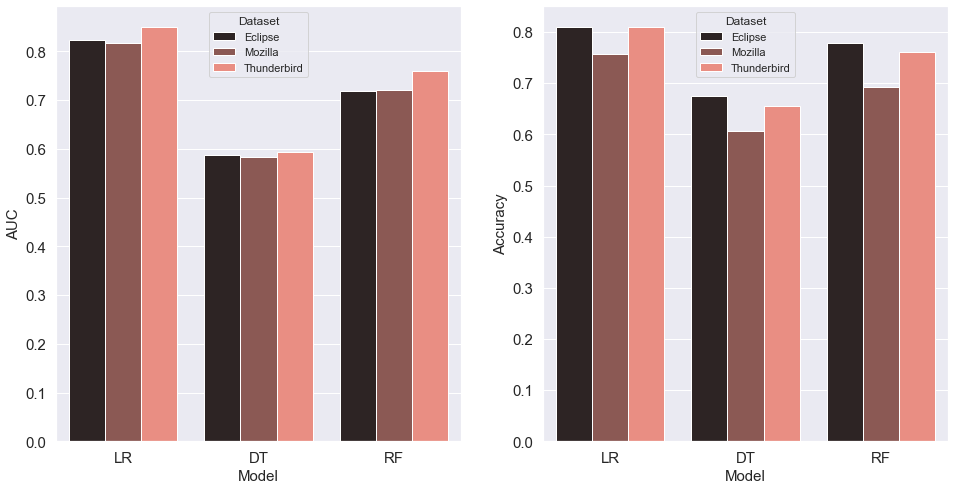

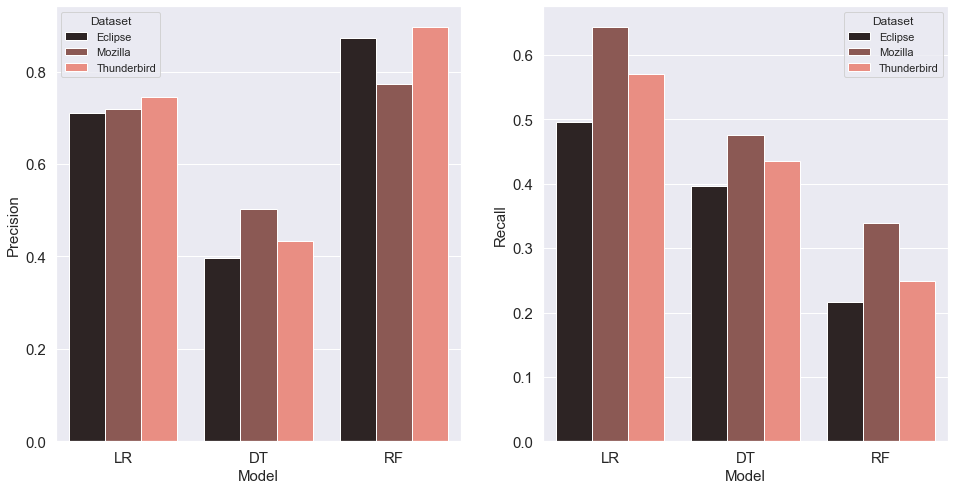

In [118]:
print("MODEL PERFORMANCE METRICS")

sns.set(style="darkgrid")

fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="Classifier", y="AUC", hue="Dataset", data=df_results,ax=axs[0],palette="dark:salmon")
ax.set_xlabel('Model',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="Classifier", y="Accuracy", hue="Dataset", data=df_results,ax=axs[1],palette="dark:salmon")
ax.set_xlabel('Model',fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.tick_params(labelsize=15)

fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="Classifier", y="Precision", hue="Dataset", data=df_results,ax=axs[0],palette="dark:salmon")
ax.set_xlabel('Model',fontsize = 15)
ax.set_ylabel('Precision', fontsize = 15)
ax.tick_params(labelsize=15)

sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="Classifier", y="Recall", hue="Dataset", data=df_results,ax=axs[1],palette="dark:salmon")
ax.set_xlabel('Model',fontsize = 15)
ax.set_ylabel('Recall', fontsize = 15)
ax.tick_params(labelsize=15)
plt.show